## Preprocessing - [run once]

In [ ]:
# WIN
!pip install psycopg2 sqlalchemy pandas cloud-sql-python-connector["pg8000"]

In [ ]:
# MAC
!pip install psycopg2-binary sqlalchemy pandas "cloud-sql-python-connector["pg8000"]"

**Could SQL Database connection method for further data analysis**

In [ ]:
import os
import pandas as pd
from google.cloud.sql.connector import Connector
from sqlalchemy import create_engine, text

# Set the environment variable GOOGLE_APPLICATION_CREDENTIALS to the file path of the JSON file that contains service account key
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "north-sea-watch-39a510f80808.json"

# Set the environment variables
DB_NAME = os.getenv("DB_NAME", "ais_data_collection")
DB_USER = os.getenv("DB_USER", "aoyamaxx")
DB_PASSWORD = os.getenv("DB_PASSWORD", "aoyamaxx")
INSTANCE_CONNECTION_NAME = "north-sea-watch:europe-west4:ais-database"

# Create a connection object
connector = Connector()

# Define a function that returns a connection object
def getconn():
    conn = connector.connect(
        INSTANCE_CONNECTION_NAME,
        "pg8000",
        user=DB_USER,
        password=DB_PASSWORD,
        db=DB_NAME,
    )
    return conn

# Create an engine object
engine = create_engine("postgresql+pg8000://", creator=getconn)

In [ ]:
# Load the ports CSV into a DataFrame
ports = pd.read_csv('data/ports.csv')

# Load the ships CSV into a DataFrame
ships = pd.read_csv('data/ships.csv')

# Load ship_data dataset from the database
query = """
SELECT * 
FROM "public"."ship_data" 
WHERE timestamp_collected >= (CURRENT_DATE - INTERVAL '7 days');
"""
with engine.connect() as conn:
    ship_data = pd.read_sql(text(query), conn)

# Display the first few rows of each dataset to verify loading
print("Ports Dataset:")
print(ports.head())

print("\nShips Dataset:")
print(ships.head())

print("\nShip Data Dataset:")
print(ship_data.head())

# Close the connector
connector.close()

In [ ]:
# Merge Datasets

# Merge ship_data with ships on imo_number
merged_data = pd.merge(ship_data, ships, on='imo_number', how='left')

# Display the first few rows of the merged dataset to verify the merge
print("Merged Dataset (ship_data with ships):")
print(merged_data.head())

# If needed, merge the resulting dataset with ports on destination port_name
# Assuming destination in ship_data corresponds to port_name in ports
ports = ports[['port_id', 'port_name', 'country']]
merged_data = pd.merge(merged_data, ports, left_on='destination', right_on='port_name', how='left')

# Display the first few rows of the final merged dataset to verify the merge
print("Final Merged Dataset (with ports):")
merged_data.head()

In [ ]:
# save dataset so i don't have to run the code again (it took 20 mins just to read in the data from the database)
merged_data.to_parquet("data/nort_sea_data.parquet", engine="pyarrow", index=False) 

## EDA - start here

In [1]:
# import statements
import pandas as pd

In [2]:
# read data
merged_data = pd.read_parquet('data/nort_sea_data.parquet')

In [3]:
# Data Cleaning and Transformation

# Handle missing values by filling or dropping them
merged_data.fillna({
    'destination': 'Unknown',
    'sog': 0,
    'cog': 0,
    'navigational_status': 'Unknown',
    'rate_of_turn': 0,
    'port_name': 'Unknown',
    'country': 'Unknown',
    'latitude_y': 0,
    'longitude_y': 0
}, inplace=True)

/var/folders/hd/mlvd77cj3kj7hwvxj8799rtr0000gn/T/ipykernel_96266/2863518010.py:4: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_data.fillna({


In [4]:
north_sea_bbox = {
    'min_latitude': 51.0,
    'max_latitude': 61.0,
    'min_longitude': -4.0,
    'max_longitude': 9.0
}

# Filter the dataset to include only data within the North Sea region
north_sea_data = merged_data[
    (merged_data['latitude'] >= north_sea_bbox['min_latitude']) &
    (merged_data['latitude'] <= north_sea_bbox['max_latitude']) &
    (merged_data['longitude'] >= north_sea_bbox['min_longitude']) &
    (merged_data['longitude'] <= north_sea_bbox['max_longitude'])
]

# Display the first few rows of the cleaned and transformed dataset
print("Cleaned and Transformed Dataset (North Sea region):")
north_sea_data.head()

Cleaned and Transformed Dataset (North Sea region):


,id,imo_number,timestamp_collected,timestamp_ais,latitude,longitude,destination,sog,cog,navigational_status,...,name,ship_type,length,width,max_draught,type_name,type_remark,port_id,port_name,country
1,9206951,9989596,2025-03-15 13:30:32.411853,2025-03-15 13:30:32.400390,53.518722,-3.219193,DREDING OPS LIVERPOL,0,0,Unknown,...,RHONE,33.0,14.0,30.0,2.0,Dredging or underwater ops,None,NaN,Unknown,Unknown
2,9206952,9082219,2025-03-15 13:30:32.424672,2025-03-15 13:30:32.413294,53.869093,8.707358,PATROL,0,0,Unknown,...,BAUMROENNE,55.0,13.0,14.0,1.4,Law Enforcement,None,NaN,Unknown,Unknown
3,9206953,1076082,2025-03-15 13:30:32.517449,2025-03-15 13:30:32.506276,51.507435,0.006850,,0,0,Unknown,...,ORBIT CLIPPER,0.0,12.0,12.0,0.0,Not available (default),None,NaN,Unknown,Unknown
4,9206954,9882607,2025-03-15 13:30:32.608735,2025-03-15 13:30:32.598254,59.611680,5.242830,NORSKEKYSTEN,0,0,Unknown,...,TAUMAR,99.0,10.0,18.0,4.8,Other Type,No additional information,NaN,Unknown,Unknown
5,9206955,9581526,2025-03-15 13:30:32.660477,2025-03-15 13:30:32.647526,51.226662,2.935090,OOSTENDE,0,0,Unknown,...,ZEETIJGER,52.0,15.0,15.0,3.3,Tug,None,NaN,Unknown,Unknown


In [5]:
north_sea_data.size, merged_data.size

(200339260, 242651310)

In [6]:
ship_categories = pd.read_csv('data/ship_type_codes.csv')

In [7]:
# Merge merged_data with ship_categories on ship_type and type_code
merged_data = pd.merge(merged_data, ship_categories, left_on='ship_type', right_on='type_code', how='left')

# Drop the original ship_type and type_code columns and rename the type column to ship_type
merged_data.drop(columns=['ship_type', 'type_code'], inplace=True)
merged_data.rename(columns={'type': 'ship_type'}, inplace=True)

# Display the first few rows of the updated dataset to verify the conversion
print("Updated Dataset with Categorical Ship Types:")
merged_data.head()

Updated Dataset with Categorical Ship Types:


,id,imo_number,timestamp_collected,timestamp_ais,latitude,longitude,destination,sog,cog,navigational_status,...,length,width,max_draught,type_name,type_remark,port_id,port_name,country,ship_type,remark
0,9206950,8200321,2025-03-15 13:30:32.320382,2025-03-15 13:30:32.310020,54.370215,10.155850,KIEL,0,0,Unknown,...,NaN,NaN,NaN,None,None,NaN,Unknown,Unknown,NaN,NaN
1,9206951,9989596,2025-03-15 13:30:32.411853,2025-03-15 13:30:32.400390,53.518722,-3.219193,DREDING OPS LIVERPOL,0,0,Unknown,...,14.0,30.0,2.0,Dredging or underwater ops,None,NaN,Unknown,Unknown,Dredging or underwater ops,NaN
2,9206952,9082219,2025-03-15 13:30:32.424672,2025-03-15 13:30:32.413294,53.869093,8.707358,PATROL,0,0,Unknown,...,13.0,14.0,1.4,Law Enforcement,None,NaN,Unknown,Unknown,Law Enforcement,NaN
3,9206953,1076082,2025-03-15 13:30:32.517449,2025-03-15 13:30:32.506276,51.507435,0.006850,,0,0,Unknown,...,12.0,12.0,0.0,Not available (default),None,NaN,Unknown,Unknown,Not available (default),NaN
4,9206954,9882607,2025-03-15 13:30:32.608735,2025-03-15 13:30:32.598254,59.611680,5.242830,NORSKEKYSTEN,0,0,Unknown,...,10.0,18.0,4.8,Other Type,No additional information,NaN,Unknown,Unknown,Other Type,No additional information


Unique IMO Data:


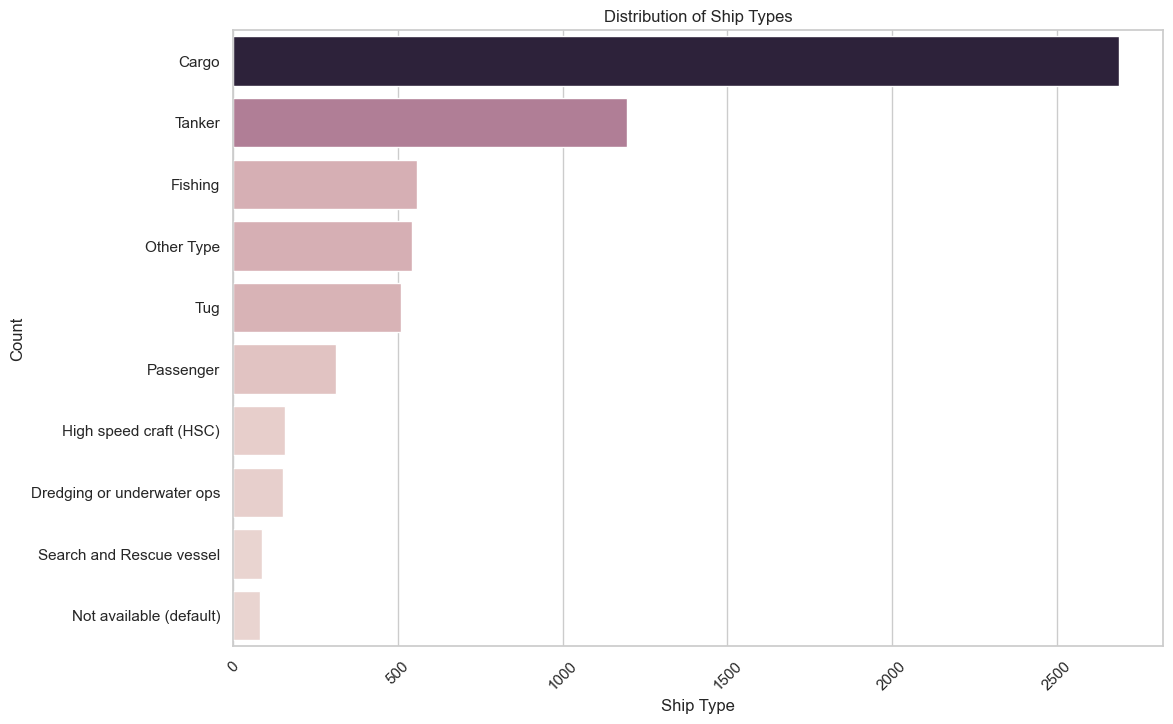

In [8]:
import seaborn as sns

import matplotlib.pyplot as plt

# Set the style for seaborn
sns.set_theme(style="whitegrid")

# Count the number of occurrences of each ship type
# Remove duplicates based on imo_number, keeping the first occurrence
unique_imo_data = merged_data.drop_duplicates(subset='imo_number', keep='first')

# Verify the result
print("Unique IMO Data:")

ship_type_counts = unique_imo_data['ship_type'].value_counts()
top_10_ship_types = ship_type_counts.head(10)
# Plot the distribution of ship types as a bar chart
plt.figure(figsize=(12, 8))
sns.barplot(x=top_10_ship_types, y=top_10_ship_types.index, hue=top_10_ship_types, legend=False)
plt.title('Distribution of Ship Types')
plt.xlabel('Ship Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

In [9]:
north_sea_data['imo_number']

1           9989596
2           9082219
3           1076082
4           9882607
5           9581526
             ...   
11029599    9102629
11029600    9815484
11029601    9662978
11029602    9465136
11029603    9579420
Name: imo_number, Length: 9106330, dtype: int64

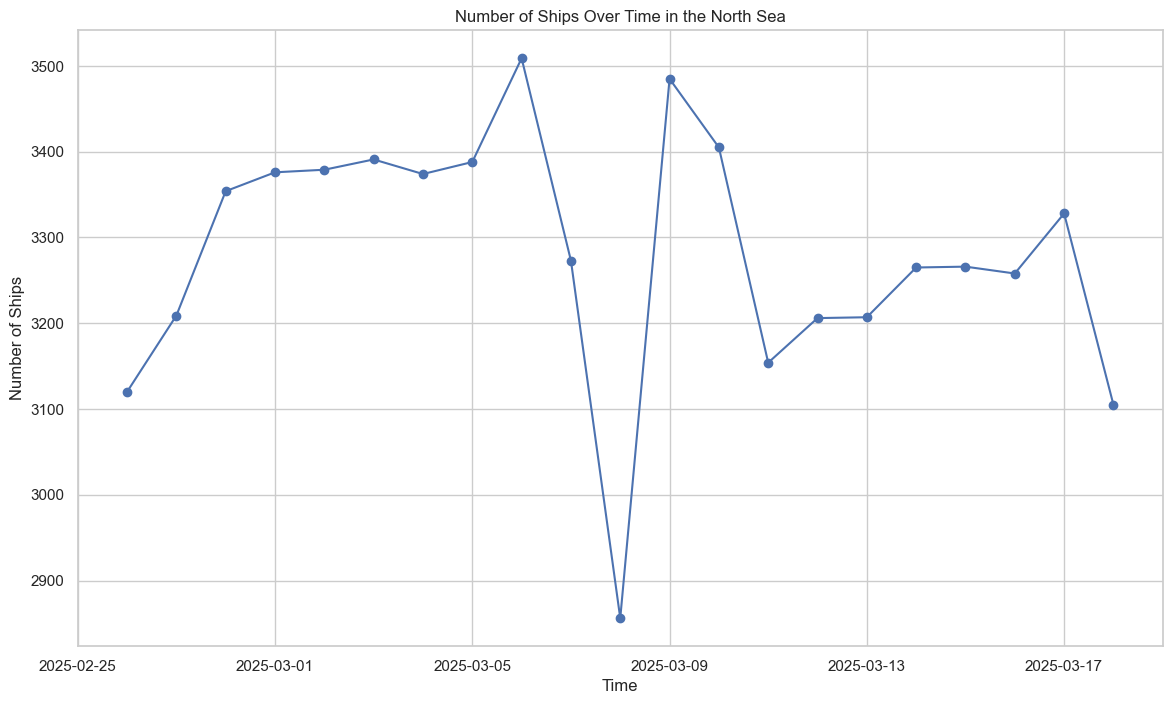

In [10]:
# Group the dataset by timestamp_collected to count the number of ships over time
ship_counts_over_time = north_sea_data.groupby([north_sea_data['timestamp_collected'].dt.date, 'imo_number']).size().groupby('timestamp_collected').size()

# Convert the PeriodIndex to a datetime index for plotting
ship_counts_over_time.index = pd.to_datetime(ship_counts_over_time.index)

# Plot the number of ships over time as a time series plot
plt.figure(figsize=(14, 8))
plt.plot(ship_counts_over_time.index, ship_counts_over_time.values, marker='o', linestyle='-')
plt.title('Number of Ships Over Time in the North Sea')
plt.xlabel('Time')
plt.ylabel('Number of Ships')
plt.grid(True)
plt.show()

In [11]:
import numpy as np

# Mapping dictionary for port abbreviations to full names
port_mapping = {
    'NLRTM': 'ROTTERDAM',  # Correct abbreviation for Rotterdam
    'NLAMS': 'AMSTERDAM',
    'NLVLI': 'VLISSINGEN',
    'BEANR': 'ANTWERP'
}

# Regex-based correction rules for various inconsistencies
corrections = {
    # Rotterdam corrections:
    r'^ROT+EDAM$': 'ROTTERDAM',         # "ROTTEDAM", "ROTEDAM", etc.
    r'^NLROTTERDAM$': 'ROTTERDAM',       # Leading abbreviation variant
    r'^ROTTERDAM.*$': 'ROTTERDAM',       # Any ROTTERDAM with extras concatenated

    # Amsterdam corrections:
    r'^AMS$': 'AMSTERDAM',              # Short form
    r'^AMSTERD[A-Z]*$': 'AMSTERDAM',     # Variants starting with AMSTERD

    # Vlissingen corrections:
    r'^VLISS?INGEN$': 'VLISSINGEN',

    # Liverpool corrections:
    r'^LIVERPOOLTUGOPS$': 'LIVERPOOL',

    # Harbour corrections:
    r'^HARBOURTOWAGE$': 'HARBOURTUG',

    # Fishing grounds corrections:
    r'^FISHINGGROUNDS?$': 'FISHING',

    # Ostende corrections:
    r'^0OSTENDE$': 'OOSTENDE',

    # Replace a single "0" with NaN later
    r'^0$': np.nan
}

# Clean and standardize the 'destination' column
unique_imo_data['destination'] = unique_imo_data['destination'].str.strip()                                   # Remove leading/trailing whitespaces
unique_imo_data['destination'] = unique_imo_data['destination'].str.upper()                                     # Uppercase all letters
unique_imo_data['destination'] = unique_imo_data['destination'].str.replace(r'\s+', '', regex=True)              # Remove all spaces
unique_imo_data['destination'] = unique_imo_data['destination'].str.replace(r'[^A-Z0-9]', '', regex=True)         # Remove special characters

# Replace abbreviations with full port names using the mapping
unique_imo_data['destination'] = unique_imo_data['destination'].replace(port_mapping)

# Apply regex correction rules for common misspellings and concatenated tokens
for pattern, replacement in corrections.items():
    if not isinstance(replacement, str):
        # Replace with an empty string then convert empty strings to NaN later
        unique_imo_data['destination'] = unique_imo_data['destination'].str.replace(pattern, '', regex=True)
    else:
        unique_imo_data['destination'] = unique_imo_data['destination'].str.replace(pattern, replacement, regex=True)

# Convert empty strings to NaN
unique_imo_data['destination'] = unique_imo_data['destination'].replace('', np.nan)

/var/folders/hd/mlvd77cj3kj7hwvxj8799rtr0000gn/T/ipykernel_96266/2737414168.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_imo_data['destination'] = unique_imo_data['destination'].str.strip()                                   # Remove leading/trailing whitespaces
/var/folders/hd/mlvd77cj3kj7hwvxj8799rtr0000gn/T/ipykernel_96266/2737414168.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_imo_data['destination'] = unique_imo_data['destination'].str.upper()                               

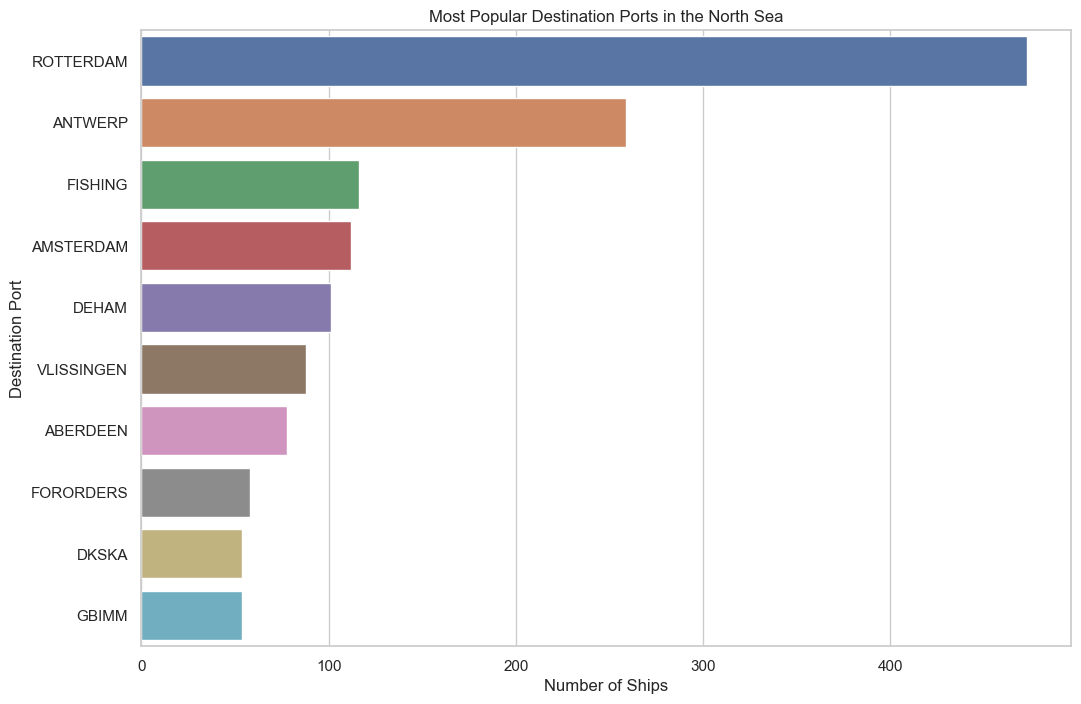

In [12]:
# Count the number of occurrences of each destination port
destination_counts = unique_imo_data['destination'].value_counts().head(10)  # Top 10 most popular destination ports

# Plot the most popular destination ports as a bar chart
plt.figure(figsize=(12, 8))
sns.barplot(x=destination_counts.values, y=destination_counts.index, hue=destination_counts.index, legend=False)
plt.title('Most Popular Destination Ports in the North Sea')
plt.xlabel('Number of Ships')
plt.ylabel('Destination Port')
plt.show()

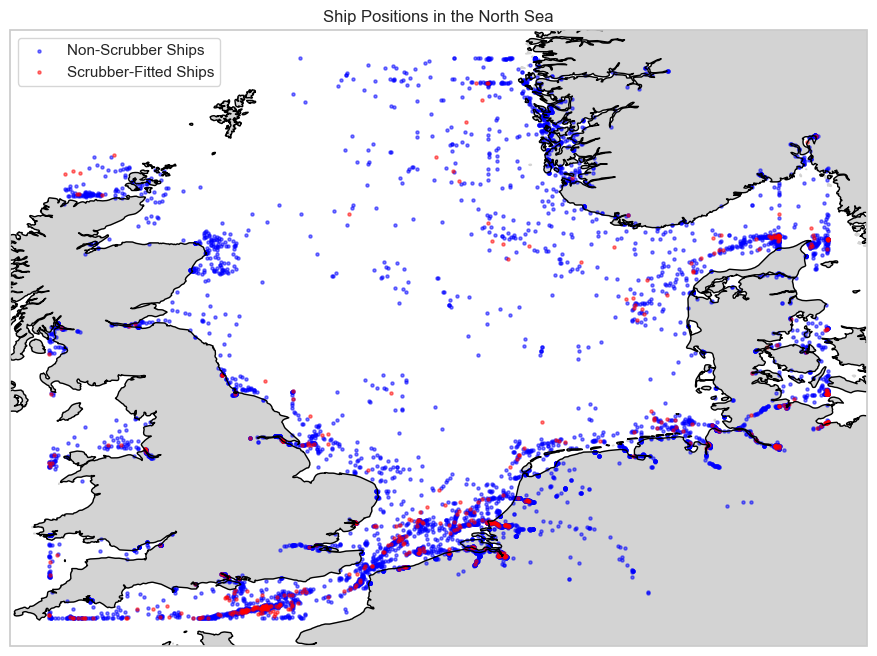

In [29]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

# Filter tanker and cargo ships separately and sample them
tankers = north_sea_data[north_sea_data['type_name'] == 'Tanker']
cargoes = north_sea_data[north_sea_data['type_name'] == 'Cargo']

sampled_tankers = tankers.sample(frac=0.18, random_state=42)
sampled_cargoes = cargoes.sample(frac=0.13, random_state=42)

scrubber_ships = pd.concat([sampled_tankers, sampled_cargoes])
non_scrubber_ships = north_sea_data[~north_sea_data['type_name'].isin(['Tanker', 'Cargo'])]

# Create the figure and add a map projection
plt.figure(figsize=(12, 8))
ax = plt.axes(projection=ccrs.PlateCarree())  # Use PlateCarree for lat/lon

# Add coastlines and land features
ax.add_feature(cfeature.COASTLINE, linewidth=1)
ax.add_feature(cfeature.LAND, color='lightgray')

# Plot ship positions
plt.scatter(non_scrubber_fitted['longitude'], non_scrubber_fitted['latitude'], alpha=0.5, c='blue', s=5, label='Non-Scrubber Ships', transform=ccrs.PlateCarree())
plt.scatter(scrubber_fitted['longitude'], scrubber_fitted['latitude'], alpha=0.5, c='red', s=5, label='Scrubber-Fitted Ships', transform=ccrs.PlateCarree())


# Labels
plt.title('Ship Positions in the North Sea')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()

# Show the plot
plt.show()

In [17]:
pip install plotly

  Using cached plotly-6.0.1-py3-none-any.whl.metadata (6.7 kB)
  Using cached narwhals-1.36.0-py3-none-any.whl.metadata (9.2 kB)
Using cached plotly-6.0.1-py3-none-any.whl (14.8 MB)
Using cached narwhals-1.36.0-py3-none-any.whl (331 kB)
  Attempting uninstall: narwhals
    Found existing installation: narwhals 1.8.2
    Uninstalling narwhals-1.8.2:
      Successfully uninstalled narwhals-1.8.2
Note: you may need to restart the kernel to use updated packages.


In [22]:
import plotly.graph_objects as go
import pandas as pd

# Remove rows with destination "FISHING" and ship_type "Other"
sankey_data = unique_imo_data[
    (unique_imo_data['destination'] != 'FISHING') &
    (unique_imo_data['ship_type'] != 'Other')
]

# Compute top 10 ship types and top 10 destination ports using the cleaned dataset
top_ship_types = sankey_data['ship_type'].value_counts().head(5).index.tolist()
top_destinations = sankey_data['destination'].value_counts().head(5).index.tolist()

# Filter data to include only top ship types and destinations
filtered = sankey_data[
    sankey_data['ship_type'].isin(top_ship_types) &
    sankey_data['destination'].isin(top_destinations)
]

# Group data by ship_type and destination
grouped = filtered.groupby(['ship_type', 'destination']).size().reset_index(name='count')

# Prepare labels and mappings for the Sankey diagram
labels = list(top_ship_types) + list(top_destinations)
ship_type_to_index = {ship: i for i, ship in enumerate(top_ship_types)}
destination_to_index = {dest: i + len(top_ship_types) for i, dest in enumerate(top_destinations)}

source = []
target = []
values = []
for _, row in grouped.iterrows():
    st = row['ship_type']
    dest = row['destination']
    if st in ship_type_to_index and dest in destination_to_index:
        source.append(ship_type_to_index[st])
        target.append(destination_to_index[dest])
        values.append(row['count'])

# Create and display the Sankey diagram as a path chart
fig = go.Figure(data=[go.Sankey(
    node=dict(
      pad=15,
      thickness=20,
      line=dict(color="black", width=0.5),
      label=labels
    ),
    link=dict(
      source=source,
      target=target,
      value=values
    )
)])
fig.update_layout(title_text="Sankey Diagram: Top Ship Types to Top Destinations", font_size=10)
fig.show()


In [33]:
import pandas as pd
import plotly.graph_objects as go

# Load scrubber data
scrubber_data = pd.read_csv('one_time_input/csvs/icct_scrubber_march_2025.csv')

# Merge scrubber data with unique_imo_data
unique_imo_data = unique_imo_data.merge(scrubber_data[['IMO Number', 'SOx Scrubber Status']])

# Add a column to indicate scrubber status
unique_imo_data['Scrubber Status'] = unique_imo_data['SOx Scrubber Status'].fillna('Non-Scrubber')

# Separate data into scrubber-fitted and non-scrubber-fitted ships
scrubber_fitted = unique_imo_data[unique_imo_data['Scrubber Status'] == 'Fitted']
non_scrubber_fitted = unique_imo_data[unique_imo_data['Scrubber Status'] == 'Non-Scrubber']

# Function to create enhanced Sankey diagram
def create_sankey(data, title):
    top_ship_types = data['ship_type'].value_counts().head(5).index.tolist()
    top_destinations = data['destination'].value_counts().head(5).index.tolist()

    filtered = data[data['ship_type'].isin(top_ship_types) & data['destination'].isin(top_destinations)]
    grouped = filtered.groupby(['ship_type', 'destination']).size().reset_index(name='count')

    labels = list(top_ship_types) + list(top_destinations)
    ship_type_to_index = {ship: i for i, ship in enumerate(top_ship_types)}
    destination_to_index = {dest: i + len(top_ship_types) for i, dest in enumerate(top_destinations)}

    source = []
    target = []
    values = []
    for _, row in grouped.iterrows():
        st = row['ship_type']
        dest = row['destination']
        if st in ship_type_to_index and dest in destination_to_index:
            source.append(ship_type_to_index[st])
            target.append(destination_to_index[dest])
            values.append(row['count'])

    # Define colors for nodes and links
    node_colors = ["#636EFA"] * len(top_ship_types) + ["#EF553B"] * len(top_destinations)
    link_colors = ["rgba(99, 110, 250, 0.6)"] * len(source)

    fig = go.Figure(data=[go.Sankey(
        node=dict(
            pad=15,
            thickness=20,
            line=dict(color='black', width=0.5),
            label=labels,
            color=node_colors
        ),
        link=dict(
            source=source,
            target=target,
            value=values,
            color=link_colors,
            hoverinfo="all"  # Updated to a valid value
        )
    )])

    # Update layout for better readability
    fig.update_layout(
        title_text=title,
        font_size=12,
        title_font_size=16,
        title_x=0.5,
        margin=dict(l=50, r=50, t=50, b=50),
        height=600
    )
    fig.show()

# Create enhanced Sankey diagrams
create_sankey(scrubber_fitted, 'Enhanced Sankey Diagram: Scrubber-Fitted Ships')
create_sankey(non_scrubber_fitted, 'Enhanced Sankey Diagram: Non-Scrubber-Fitted Ships')

In [ ]:
# SQL query to remove duplicate ship records based on key fields, keeps the oldest one
'''
DELETE FROM public.ship_data AS s
USING (
    SELECT id, 
           ROW_NUMBER() OVER (
               PARTITION BY imo_number, timestamp_ais, latitude, longitude, destination, sog, cog, 
                            navigational_status, rate_of_turn
               ORDER BY timestamp_collected ASC
           ) AS row_num
    FROM public.ship_data
) AS duplicates
WHERE s.id = duplicates.id AND duplicates.row_num > 1;
'''